# AlexNet 神经网络可视化

利用pytorch中已预置和训练好的AlexNet（torchvision.models.alexnet），输入一张自己拍摄的鲜花或校园风景图片进行分类。

直接访问模型的子模块，在前向传播中逐步计算每一层的输出，可视化AlexNet中8个层的中间结果。

选取每个层中有代表性的一部分放在作业文字报告中。

解释模型的处理过程，讨论模型的分类结果。

## 分类测试

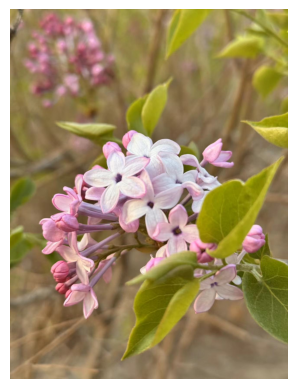


Top 5 预测结果：
sulphur butterfly: 66.11%
small white: 6.80%
monarch butterfly: 4.02%
bee: 3.92%
hummingbird: 3.19%


In [7]:
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# 1. 加载预训练的AlexNet模型
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
model.eval()  # 设置为评估模式

# 2. 图像预处理
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 3. 加载并预处理图像
image_path = "./flower.jpg"  # 替换为你的图片路径
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # 添加batch维度

# 4. 进行预测
with torch.no_grad():
    output = model(input_batch)

# 5. 解析预测结果
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# 下载ImageNet类别标签
import requests
imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = requests.get(imagenet_labels_url).json()

# 获取top5预测结果
top5_prob, top5_catid = torch.topk(probabilities, 5)
print("\nTop 5 预测结果：")
for i in range(top5_prob.size(0)):
    print(f"{labels[top5_catid[i]]}: {top5_prob[i].item()*100:.2f}%")

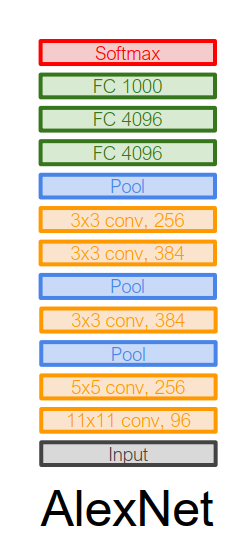

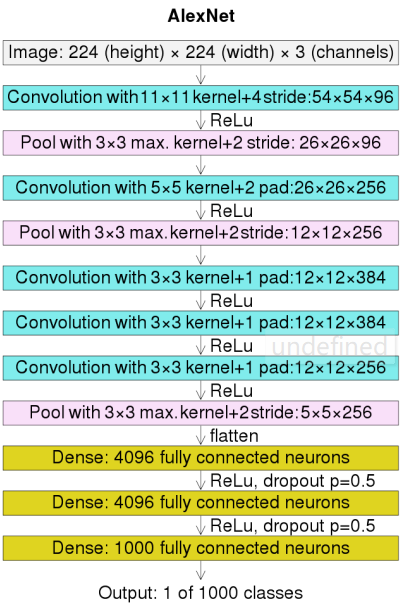

In [9]:
# 选择要可视化的8个关键层（包含卷积和池化层）
target_layers = {
    'conv1': model.features[0],       # 第一个卷积层
    'pool1': model.features[2],       # 第一个池化层
    'conv2': model.features[3],       # 第二个卷积层
    'pool2': model.features[5],       # 第二个池化层
    'conv3': model.features[6],       # 第三个卷积层
    'conv4': model.features[8],       # 第四个卷积层
    'conv5': model.features[10],      # 第五个卷积层
    'pool5': model.features[12],      # 最后一个池化层
}

# 存储激活输出的字典
activation = {}

def get_activation(name):
    """钩子函数，用于捕获各层输出"""
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# 注册钩子
for name, layer in target_layers.items():
    layer.register_forward_hook(get_activation(name))

# 前向传播获取中间结果
with torch.no_grad():
    _ = model(input_batch)

<Figure size 2000x3000 with 0 Axes>

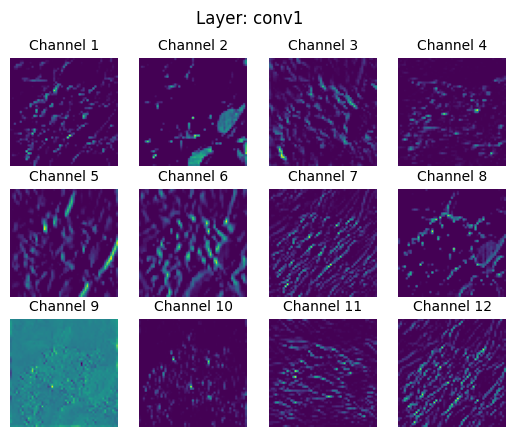

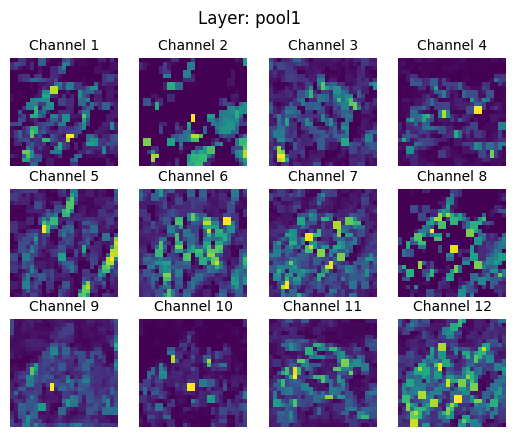

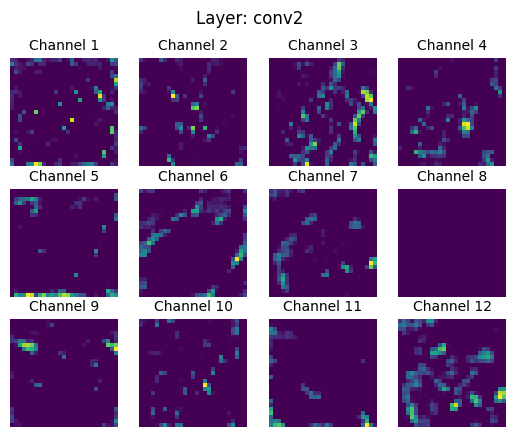

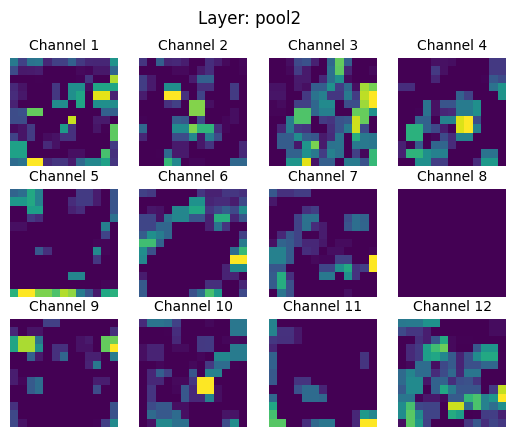

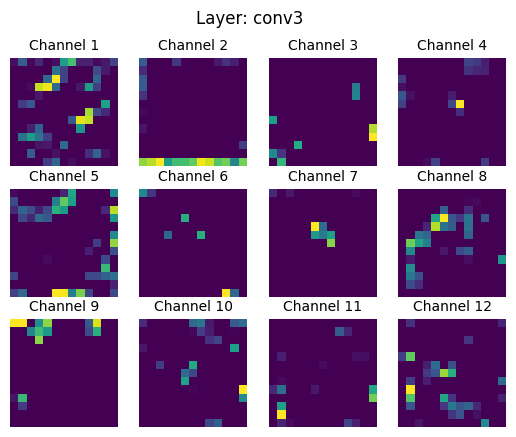

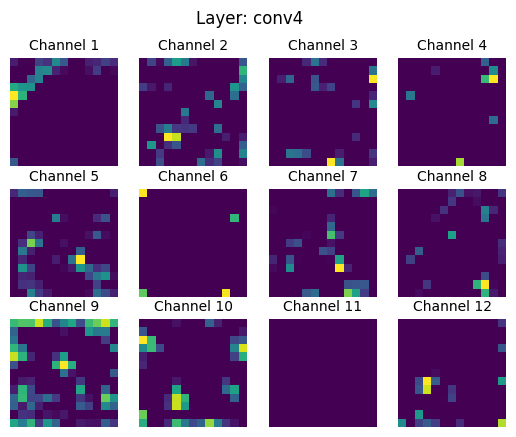

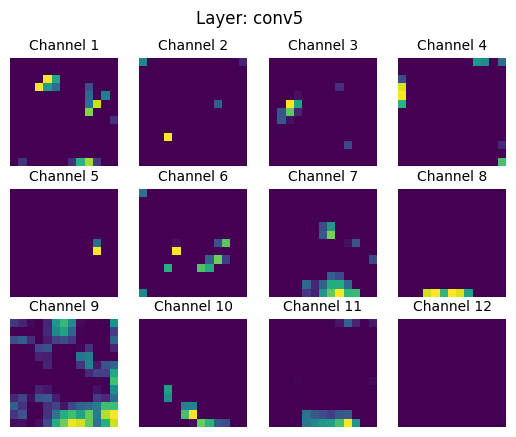

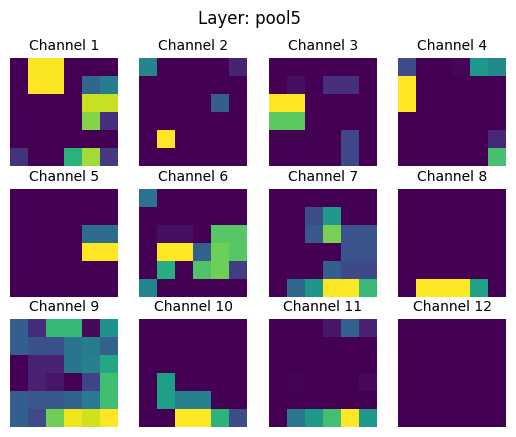

In [ ]:
# 可视化函数
def visualize_activations(activation_dict):
    plt.figure(figsize=(20, 30))
    
    for i, (layer_name, outputs) in enumerate(activation_dict.items()):
        img = torch.squeeze(outputs)
        img = img.detach().cpu().numpy()
        num_channel = img.shape[0]
        num = num_channel if num_channel < 12 else 12
        fig = plt.figure()
        fig.suptitle(f"Layer: {layer_name}")
        for i in range(num):
            plt.subplot(3, 4, i + 1)
            plt.axis('off')
            plt.imshow(img[i, :, :])
            plt.title(f"Channel {i+1}", fontsize=10)
        plt.show()

# 可视化
visualize_activations(activation)